## Capstone Milestone Report

Jonathan Werberg

### Create a model to predict prices of individual co-op units in Queens, NY

Using historical sales and other data build a model to best predict current sales prices for NYC co-op apartments.  ACRIS public data will form the core dataset. Features may include prior sales, floor and line of the unit, time since last sale, and adjustments for overall neighborhood and borough trends.

### Data set

NYC's ACRIS (Automated City Register Information System) data contains information on apartment sales.  Key fields are:

- Date of transaction
- Address of unit (street number, street name and unit) 
- Transaction amount 

NYC PLUTO (Primary Land Use Tax Lot Output) data is also used to get master list of potential co-ops of interest.  It contains info on the number of buildings, floors and apartments and can be limited to co-op property types.  

### Data wrangling and cleaning

- Data is downloaded via API calls to NYC Open Data 
- First a set of document ID's must be found that match the co-op from one API endpoint.  Then a second call pulls down additional information for those transactions and these two sets are merged.
- Data caching has been setup so if data has already been downloaded its loaded from a local copy.  [needs to be improved to check for new results]
- Data cleaning involves fixing date formats, limiting to the appropriate document types, excluding outliers [currently done with fixed cutoff, should be further tested to see if there is a more dynamic approach]

### Limitations

- These public datasets lack some key attributes that would be extremely valuable like number of bedrooms, number of bathrooms.  I am continuing to look for additional sources or ways to proxy or estimate for those attributes.  
- We also lack access to information on monthly maintanence/carrying costs that can have a dramatic impact on sale prices.  We can mitigate for this to some extent by comparing within the same co-op which will have a consistent maintanence cost structure but makes comparisons between co-ops more difficult.  

### Prelimiary analysis

- I have run some basic initial analysis, visualizing prices over time and looking at differences by line, floor, building number.  Clearly time/overall market prices are important factors so have needed to adjust for that.  Initial approach has been to take rolling average of previous ten sales.
- Did a few basic regressions taking into account rolling average of previous sales and other factors either directly available from data (line, floor, building number) or manually coding variables where know (bedrooms, best views)

Inital libraries

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import os
import string
from statsmodels.formula.api import ols
import statsmodels.api as sm

## Function to retrieve data

In [2]:
# here take as input a BBL 
# see if data file exists, if so just use that
# if not, pull down data from opendata, match the two needed datasets and save
# todo - make this check for updated data

In [3]:
def get_and_cache_bbl_data(bbl=(4,528,50),filename='coopdata.csv'):
    if os.path.isfile(filename):
        print 'reading data from cache...'
        df = pd.read_csv(filename)
        print len(df),'records'
        return df
    else:
        print 'no cache found, pulling data from web...'
        url='https://data.cityofnewyork.us/resource/8h5j-fqxa.csv?borough='
        url+=str(bbl[0])+'&block='+str(bbl[1])+'&lot='+str(bbl[2])
        df=pd.read_table(url,sep=',')
        docids = df['DOCUMENT ID']
        urlbase="https://data.cityofnewyork.us/resource/bnx9-e6tj.csv?$where=document_id='"
        l = len(docids)
        n = l // 100 
        masterlist = [] 
        for i in range(n+1):
            if i < n:
                url = urlbase + "'%20or%20document_id='".join(docids[i*100:(i+1)*100]) + "'"
                #print url 
                masterlist.append(pd.read_table(url,sep=','))
            else:
                url=urlbase + "'%20or%20document_id='".join(docids[i*100:l]) + "'"
                #print url
                masterlist.append(pd.read_table(url,sep=',')) 
        masters = pd.concat(masterlist)
        mergeddf = pd.merge(df,masters,on=['DOCUMENT ID'])
        mergeddf.columns = mergeddf.columns.str.replace(' ','')
        mergeddf.columns = mergeddf.columns.str.replace('.','')
        mergeddf.columns = mergeddf.columns.str.lower()
        print 'saving to file',filename
        mergeddf.to_csv(filename)
        print len(mergeddf), 'records'
        return mergeddf

## Function to clean data

In [5]:
# make and clean and prep data function
# limit to RPTT
# todo: 
# fix dates and be robust for missing dates 
# get rid of outlier values - 0 and more than X std from nearby avg? or just low/high values? 
# setup line, floor, bldgnum variables 
# calculate previous sale of same unit 


In [6]:
#quick trimming a string down to just digits 
#from: http://stackoverflow.com/questions/1450897/python-removing-characters-except-digits-from-stringx
all=string.maketrans('','')
nodigs=all.translate(all, string.digits)
#then use as string.translate(all, nodigs)
def justdigits(string):
    return int(string.translate(all,nodigs))
    
# eg justdigits('10A') returns 10 

In [16]:
def clean_and_prep_data(mergeddf,minsale=100000):
    sales=mergeddf[mergeddf.doctype.str.startswith('RPTT')]
    sales['date'] = [ datetime.strptime(date_string, '%m/%d/%Y') for date_string in sales['docdate'] ]
    sales = sales[sales.docamount>minsale]
    # will need to do alpha check in case units listed as A1 
    sales['line']=[s[-1:] for s in sales.unit]
    sales['floor']=[justdigits(s) for s in sales['unit']]
    sales = sales.set_index('date').sort_index()
    sales['bldgnum']=[str(justdigits(s)) for s in sales['streetnumber']]
    return sales

## Retrieving data for test case of one co-op

In [4]:
mergeddf=get_and_cache_bbl_data(filename='coopdata.csv')

reading data from cache...
185 records


## Cleaning data for test case

In [17]:
sales = clean_and_prep_data(mergeddf)

/Users/helene/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Manual coding variables where we have info

In [50]:
# Local knowledge that I have 
sales['bedrooms'] = [str(2+ (b in ['3368','3360','3347'])) for b in sales.bldgnum]
#sales['view']
sales['view'] = [((line in ['B','C']) & (floor>9) & (bldg in ['3365','3355','3343'])) 
                 for (line,floor,bldg) in sales[['line','floor','bldgnum']].values]

## Preview coded data

In [51]:
sales.head()

,Unnamed: 0,documentid,recordtype_x,borough_x,block,lot,easement,partiallot,airrights,subterraneanrights,...,reelnbr,reelpage,%transferred,goodthroughdate_y,line,floor,bldgnum,bedrooms,view,rm
date,,,,,,,,,,,,,,,,,,,,,
2004-06-21,19,2006011201300001,L,4,528,50,N,E,N,N,...,0,0,100,07/31/2015,C,7,3343,2,False,NaN
2004-07-08,78,2004080300906001,L,4,528,50,N,E,N,N,...,0,0,100,07/31/2015,A,15,3343,2,False,165000
2004-08-09,88,2004082000656001,L,4,528,50,N,E,N,N,...,0,0,100,07/31/2015,C,3,3360,3,False,172500
2004-09-14,84,2004092800386001,L,4,528,50,N,E,N,N,...,0,0,100,07/31/2015,A,5,3365,2,False,180000
2004-09-23,159,2004092301700001,L,4,528,50,N,E,N,N,...,0,0,100,07/31/2015,D,4,3355,2,False,168750


## Add in rolling means

In [38]:
sales['rm']=pd.rolling_mean(sales.docamount,10,min_periods=1).shift(+1)

## Plot of prices over time and rolling means

- Red line rolling mean of prior 10 sales
- Yellow line has exponential decay of sale prices (so more recent sales count more)

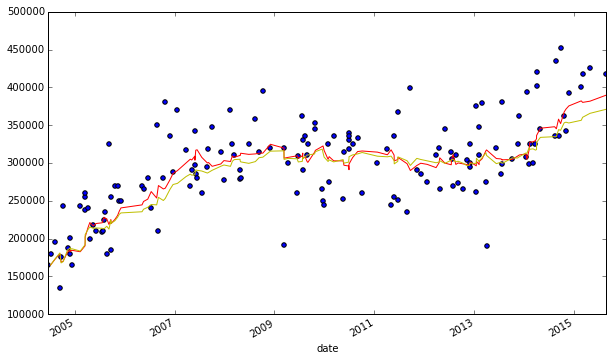

In [39]:
plt.figure(figsize=(10,6))
x=sales.index.values
y=sales.docamount
plt.scatter(x,y)
pd.rolling_mean(sales.docamount,10,min_periods=1).shift(+1).plot(style='r')
pd.ewma(sales.docamount,10,min_periods=1).shift(+1).plot(style='y')
plt.show()

### Regressions of prices based on prior sales, line floor and building number
 
- Provides good fit with adjusted R^2 = 0.728

In [40]:
results = ols(formula="docamount ~ rm + line + floor + bldgnum", data=sales).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              docamount   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     37.81
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           1.52e-36
Time:                        15:29:51   Log-Likelihood:                -1784.5
No. Observations:                 152   AIC:                             3593.
Df Residuals:                     140   BIC:                             3629.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -3.424e+04   1.89e+04     -1.808      0.073     -7.17e+04  3198.050
line[T.B]        7292.8308   6976.800      1.045      0.298     -6500.677  2.11e+04
line[T.C]        1.113e+04   7088.964      1.570      0.119     -2888.468  2.51e+04
line[T.D]        1.001e+04   7647.090      1.309      0.193     -5108.804  2.51e+04
bldgnum[T.3347]  4.951e+04   1.07e+04      4.612      0.000      2.83e+04  7.07e+04
bldgnum[T.3355]  -560.8478   9086.106     -0.062      0.951     -1.85e+04  1.74e+04
bldgnum[T.3360]  5.477e+04   8741.035      6.266      0.000      3.75e+04  7.21e+04
bldgnum[T.3364] -4015.5680   9588.145     -0.419      0.676      -2.3e+04  1.49e+04
bldgnum[T.3365] -1.472e+04   8512.701     -1.730      0.086     -3.16e+04  2106.263
bldgnum[T.3368]  4.508e+04   9700.784      4.647      0.000      2.59e+04  6.43e+04
rm                  0.9893      0.056     17.754      0.000         0.879     1.100
floor            3004.5522    657.826      4.567      0.000      1703.995  4305.110
==============================================================================
Omnibus:                        5.750   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.289
Skew:                          -0.413   Prob(JB):                       0.0711
Kurtosis:                       3.392   Cond. No.                     2.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression - addding interaction for building-line

- Caution - these interaction terms leave fairly small group sizes, averaging around 5 and most as few as 2. 
- Only improves model very slightly to adjusted R^2 of 0.748, probably overfitting and not worth it 

bldgnum  line
3343     A       9
         B       8
         C       8
         D       5
3347     A       6
         B       3
         C       2
         D       2
3355     A       4
         B       5
         C       8
         D       5
3360     A       7
         B       5
         C       5
         D       8
3364     A       5
         B       5
         C       9
3365     A       8
         B       7
         C       6
         D       6
3368     A       7
         B       5
         C       2
         D       3
dtype: int64

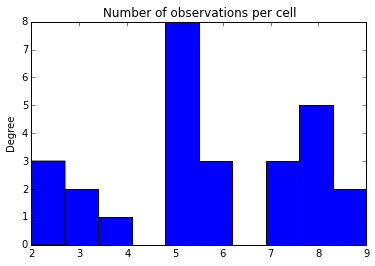

In [65]:
sales.groupby(['bldgnum','line']).size().plot(kind='hist',title='Number of observations per cell')
sales.groupby(['bldgnum','line']).size()

In [41]:
results = ols(formula="docamount ~ rm + line + floor + bldgnum + line*bldgnum", data=sales).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              docamount   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     17.01
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           3.08e-30
Time:                        15:29:55   Log-Likelihood:                -1768.9
No. Observations:                 152   AIC:                             3596.
Df Residuals:                     123   BIC:                             3684.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                 -3.538e+04   2.04e+04     -1.738      0.085     -7.57e+04  4921.748
line[T.B]                 -8758.8611   1.49e+04     -0.587      0.558     -3.83e+04  2.08e+04
line[T.C]                  7244.3603   1.55e+04      0.468      0.640     -2.34e+04  3.79e+04
line[T.D]                  2874.1182    1.7e+04      0.169      0.866     -3.08e+04  3.65e+04
bldgnum[T.3347]            4.972e+04   1.61e+04      3.092      0.002      1.79e+04  8.15e+04
bldgnum[T.3355]            1.138e+04   1.85e+04      0.614      0.540     -2.53e+04   4.8e+04
bldgnum[T.3360]            5.574e+04   1.55e+04      3.592      0.000       2.5e+04  8.65e+04
bldgnum[T.3364]           -4.736e+04    1.7e+04     -2.781      0.006     -8.11e+04 -1.36e+04
bldgnum[T.3365]           -1.855e+04   1.48e+04     -1.253      0.213     -4.79e+04  1.08e+04
bldgnum[T.3368]                3e+04   1.54e+04      1.952      0.053      -415.199  6.04e+04
line[T.B]:bldgnum[T.3347] -8893.3131   2.65e+04     -0.336      0.738     -6.13e+04  4.35e+04
line[T.C]:bldgnum[T.3347]  2.106e+04   2.98e+04      0.706      0.481     -3.79e+04  8.01e+04
line[T.D]:bldgnum[T.3347] -1.255e+04   3.02e+04     -0.416      0.678     -7.23e+04  4.72e+04
line[T.B]:bldgnum[T.3355]  3652.7452   2.53e+04      0.144      0.886     -4.65e+04  5.38e+04
line[T.C]:bldgnum[T.3355] -2.251e+04   2.44e+04     -0.924      0.357     -7.07e+04  2.57e+04
line[T.D]:bldgnum[T.3355] -1.766e+04   2.67e+04     -0.660      0.510     -7.06e+04  3.53e+04
line[T.B]:bldgnum[T.3360] -3213.8597   2.34e+04     -0.137      0.891     -4.96e+04  4.32e+04
line[T.C]:bldgnum[T.3360] -1.087e+04   2.39e+04     -0.455      0.650     -5.82e+04  3.65e+04
line[T.D]:bldgnum[T.3360]  5478.7121   2.33e+04      0.235      0.814     -4.06e+04  5.16e+04
line[T.B]:bldgnum[T.3364]  6.484e+04   2.45e+04      2.644      0.009      1.63e+04  1.13e+05
line[T.C]:bldgnum[T.3364]  5.498e+04   2.32e+04      2.375      0.019      9152.130  1.01e+05
line[T.D]:bldgnum[T.3364]  -1.46e-08   1.35e-08     -1.082      0.281     -4.13e-08  1.21e-08
line[T.B]:bldgnum[T.3365]  5224.6908   2.17e+04      0.241      0.810     -3.77e+04  4.82e+04
line[T.C]:bldgnum[T.3365] -6522.9050   2.26e+04     -0.289      0.773     -5.13e+04  3.82e+04
line[T.D]:bldgnum[T.3365]  1.644e+04   2.37e+04      0.694      0.489     -3.04e+04  6.33e+04
line[T.B]:bldgnum[T.3368]  5.576e+04   2.32e+04      2.404      0.018      9838.890  1.02e+05
line[T.C]:bldgnum[T.3368] -8552.4656    2.9e+04     -0.295      0.769      -6.6e+04  4.89e+04
line[T.D]:bldgnum[T.3368] -3149.8826   2.71e+04     -0.116      0.908     -5.68e+04  5.05e+04
rm                            1.0123      0.057     17.763      0.000         0.900     1.125
floor                      3122.7402    669.458      4.665      0.000      

### Regressions using rolling mean and know characteristics: bedrooms and skyline views

- Adjusted R^2 = 0.689
- Fairly strong but not as good as just using generic building, line and floor numbers

In [52]:
results = ols(formula="docamount ~ rm + bedrooms + view", data=sales).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              docamount   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     111.5
Date:                Sat, 07 Nov 2015   Prob (F-statistic):           8.56e-38
Time:                        15:44:38   Log-Likelihood:                -1799.5
No. Observations:                 152   AIC:                             3607.
Df Residuals:                     148   BIC:                             3619.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        87.7066   1.75e+04      0.005      0.996     -3.45e+04  3.47e+04
bedrooms[T.3]  5.723e+04   6024.833      9.498      0.000      4.53e+04  6.91e+04
view[T.True]   3752.4876   8523.739      0.440      0.660     -1.31e+04  2.06e+04
rm                0.9552      0.058     16.370      0.000         0.840     1.071
==============================================================================
Omnibus:                       15.267   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.618
Skew:                          -0.681   Prob(JB):                     0.000149
Kurtosis:                       3.961   Cond. No.                     1.88e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""